# Compare Single Cell Profile Reproducibility

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggridges))
suppressPackageStartupMessages(library(corrplot))

In [2]:
set.seed(123)

In [3]:
process_results <- function(plate_id, sc_type='isolated', num_sample=500) {
    # Retrieve results for the plate and sc_type
    #
    # Arguments:
    # plate_id - string indicating which plate to focus on
    # sc_type - string indicating which type of sc to focus on
    #           isolated cells or colonies
    # num_sample - how many permuted samples to include in correlation
    #
    # Output:
    # a processed data frame of results
    
    # Step 1: Read in both batches of data
    profile_dir <- file.path("..", "..", "..", "backend", "2019_05_13_Batch2")
    profile_file <- file.path(profile_dir,
                              plate_id,
                              paste0(plate_id,
                                     "_normalized_variable_selected.csv"))

    profile_cols <- readr::cols(
        .default = readr::col_double(),
        Metadata_Plate = readr::col_character(),
        Metadata_Well = readr::col_character(),
        Metadata_Assay_Plate_Barcode = readr::col_character(),
        Metadata_Plate_Map_Name = readr::col_character(),
        Metadata_well_position = readr::col_character(),
        Metadata_plating_density = readr::col_integer(),
        Metadata_line_ID = readr::col_character(),
        Metadata_timepoint = readr::col_integer()
    )

    profile_df <- readr::read_csv(profile_file,
                                  col_types = profile_cols)
    
    # Extract metadata columns
    metadata_df <- profile_df %>%
        dplyr::select(starts_with("Metadata_"))
    
    # Step 2: Read in single cell data
    sc_cols <- readr::cols(
        .default = readr::col_double(),
        ImageNumber = readr::col_integer(),
        ObjectNumber = readr::col_integer(),
        Metadata_Well = readr::col_character(),
        Metadata_Plate = readr::col_character(),
        Cells_Neighbors_SecondClosestObjectNumber_Adjacent = readr::col_integer()
    )

    file <- file.path("data",
                      paste0(plate_id, "_single_cell_", sc_type, "_profiles.tsv.gz"))
    sc_df <- readr::read_tsv(file,
                             col_types = sc_cols) %>%
        dplyr::left_join(
            metadata_df,
            by = c("Metadata_Plate", "Metadata_Well")
        )
    
    # Extract metadata and cell profiler features
    cp_metadata <-
     colnames(sc_df) %>%
        stringr::str_subset("^Metadata_")

    cp_features <-
     colnames(sc_df) %>%
        stringr::str_subset("^Nuclei_|^Cells_|^Cytoplasm_")
    
    # Retrieve number of cells per condition
    num_cell_df <- sc_df %>%
        dplyr::group_by(Metadata_line_ID, Metadata_timepoint, Metadata_plating_density) %>%
        dplyr::count() %>%
        dplyr::mutate(plate_id = plate_id,
                      sc_type = sc_type)
    
    # Step 3: Loop over each well on the plate and extract correlation results
    full_result_list <- list()
    for (well in unique(sc_df$Metadata_Well)) {

        # Get all of the data of single cells from that well
        well_sc_df <- sc_df %>%
            dplyr::filter(Metadata_Well == well)

        # Acquire metadata for the cells in the specific well
        real_subset_metadata_df <- well_sc_df %>%
            dplyr::select(cp_metadata) %>%
            dplyr::mutate(dictionary_id = paste0("real", 1:n())) %>%
            dplyr::mutate(comparison = "real")

        # Extract certain metadata characteristics that will be important later
        num_cells <- nrow(real_subset_metadata_df)
        well_num <- unique(real_subset_metadata_df$Metadata_Well)
        timepoint <- unique(real_subset_metadata_df$Metadata_timepoint)
        density <- unique(real_subset_metadata_df$Metadata_plating_density)
        cell_id <- unique(real_subset_metadata_df$Metadata_line_ID)

        # Randomly sample other cells from from the matched condition 
        random_matched_sc_df <- sc_df %>%
            dplyr::filter(Metadata_Well != well,
                          Metadata_timepoint == timepoint,
                          Metadata_plating_density == density,
                          Metadata_line_ID != cell_id) %>%
            dplyr::sample_n(size = num_sample)

        # Get the random metadata too
        random_subset_metadata_df <- random_matched_sc_df %>%
            dplyr::select(cp_metadata) %>%
            dplyr::mutate(dictionary_id = paste0("permuted", 1:n())) %>%
            dplyr::mutate(comparison = "permuted")

        # Combine the profiles and metadata
        combined_well_sc_df <- well_sc_df %>%
            dplyr::bind_rows(random_matched_sc_df)

        combined_metadata_df <- real_subset_metadata_df %>%
            dplyr::bind_rows(random_subset_metadata_df)

        # Get the full correlation matrix
        combined_sc_cor_df <- combined_well_sc_df %>%
            dplyr::select(cp_features) %>%
            t() %>%
            cor(method = "spearman") %>%
            dplyr::as_tibble() %>%
            magrittr::set_colnames(combined_metadata_df$dictionary_id)

        # Melt the correlation matrix for plotting
        well_cor_df <- combined_metadata_df %>%
            dplyr::bind_cols(
                replace(combined_sc_cor_df,
                        lower.tri(combined_sc_cor_df, TRUE), NA)
            ) %>%
            dplyr::select(-cp_metadata) %>%
            reshape2::melt(id.vars = c('dictionary_id',
                                       "comparison"),
                           variable.name = 'correlation_id', 
                           value.name = "pearson_cor",
                           na.rm = TRUE) %>%
            dplyr::filter(
                !(grepl("permuted", correlation_id) &
                  grepl("permuted", dictionary_id)),
                dictionary_id != correlation_id
            ) %>%
            dplyr::mutate(
                comparison=replace(comparison,
                                   grepl("permuted", correlation_id), "permuted"),
                comparison=replace(comparison,
                                   grepl("real", correlation_id), "real")
            )

        # Summarize the results
        summary_result_df <- well_cor_df %>%
            dplyr::group_by(comparison) %>%
            dplyr::summarize(median_val = median(pearson_cor, na.rm = TRUE),
                             low_ci = quantile(pearson_cor, 0.05),
                             high_ci = quantile(pearson_cor, 0.95)) %>%
            dplyr::mutate(num_cells = num_cells,
                          well_num = well_num,
                          timepoint = timepoint,
                          density = density,
                          cell_id = cell_id)

        full_result_list[[well]] <- summary_result_df
    }
    
    # Step 4: Process output
    full_result_df <- as.data.frame(do.call(rbind, full_result_list))
    full_result_df <- full_result_df %>%
        dplyr::mutate(plate_id = plate_id,
                      sc_type = sc_type)
    return(list(full_result_df, num_cell_df))
}

In [4]:
plate_ids <- c("BR00103267", "BR00103268")
sc_types <- c("isolated", "colony")

all_results_list <- list()
num_cell_list <- list()
for (plate_id in plate_ids) {
    for (sc_type in sc_types) {
        
        result_name <- paste0(plate_id, "_", sc_type)
        print(result_name)

        full_results <- process_results(plate_id=plate_id,
                                        sc_type=sc_type,
                                        num_sample=500)

        all_results_list[[result_name]] <- full_results[[1]]
        num_cell_list[[result_name]] <- full_results[[2]]
    }
}

[1] "BR00103267_isolated"


Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

[1] "BR00103267_colony"
[1] "BR00103268_isolated"
[1] "BR00103268_colony"


In [5]:
file <- file.path("results", "num_single_cells_per_condition.tsv")
readr::write_tsv(num_cell_df, file)

ERROR: Error in is.data.frame(x): object 'num_cell_df' not found


In [6]:
plot_ready_df <- as.data.frame(do.call(rbind, all_results_list))

dim(plot_ready_df)
head(plot_ready_df)

[1] 3054   11

,comparison,median_val,low_ci,high_ci,num_cells,well_num,timepoint,density,cell_id,plate_id,sc_type
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
BR00103267_isolated.1,permuted,0.8788646,0.7920892,0.9265287,121,A01,6,5000,A,BR00103267,isolated
BR00103267_isolated.2,real,0.8983973,0.8326106,0.9353029,121,A01,6,5000,A,BR00103267,isolated
BR00103267_isolated.3,permuted,0.8726304,0.7731969,0.9248136,153,A02,6,5000,A,BR00103267,isolated
BR00103267_isolated.4,real,0.8912284,0.7995298,0.9302763,153,A02,6,5000,A,BR00103267,isolated
BR00103267_isolated.5,permuted,0.8480020,0.7514357,0.9105183,371,A03,6,15000,B,BR00103267,isolated
BR00103267_isolated.6,real,0.8459468,0.7413723,0.9103221,371,A03,6,15000,B,BR00103267,isolated


In [7]:
file <- file.path("results", "spearman_correlation_single_cells_per_condition.tsv")
readr::write_tsv(plot_ready_df, file)

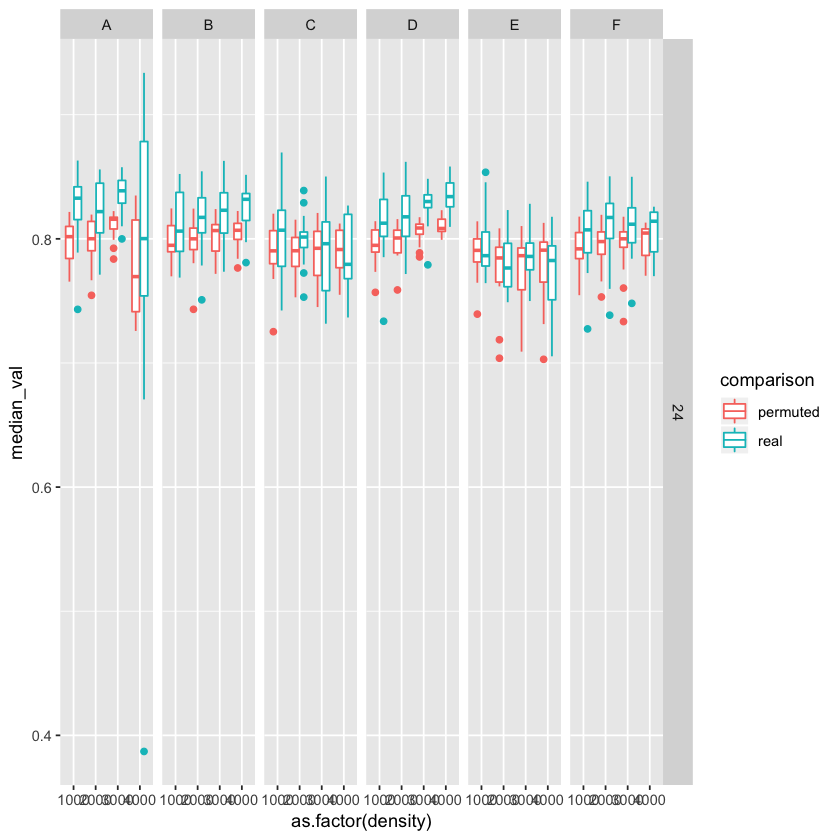

In [19]:
ggplot(full_result_df, aes(x = as.factor(density),
                           y = median_val,
                           color = comparison)) +
    geom_boxplot() +
    facet_grid(timepoint ~ cell_id)

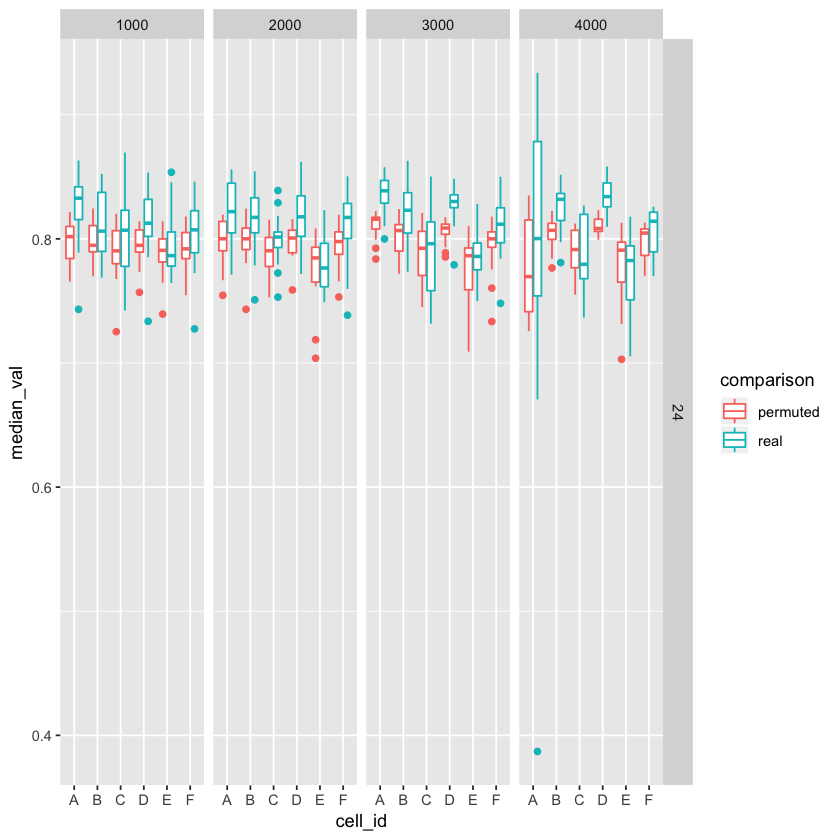

In [13]:
ggplot(full_result_df, aes(x = cell_id,
                           y = median_val,
                           color = comparison)) +
    geom_boxplot() +
    facet_grid(timepoint ~ density)